<a href="https://colab.research.google.com/github/lorenzo-stacchio/Fashion-in-The-Metaverse-Tutorial/blob/main/Artificial%20Intelligence/Fashion_in_the_Metaverse_SDreamF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fashion in the Metaverse - Stable DreamFusion google colab** 🎨
<div align="center">
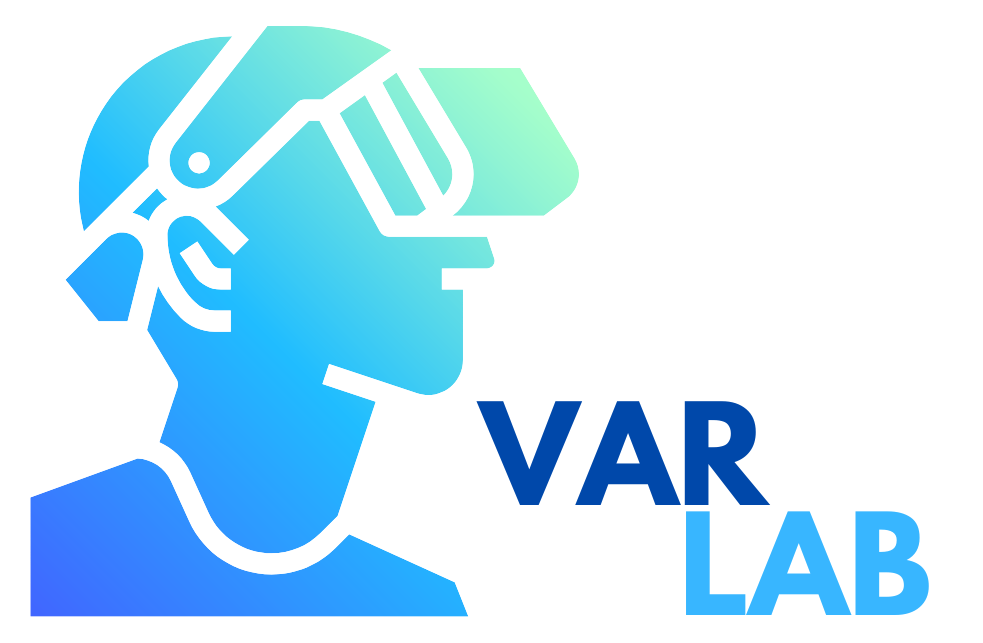
</div>

This Colab notebook shows how to exploit Text-to-3D DreamFusion approach by using [original repository code](https://github.com/ashawkey/stable-dreamfusion).



### Check the machine

In [1]:
! nvidia-smi

Mon Nov 13 14:18:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Setup

In [ ]:
#@title install dependencies
! git clone https://github.com/ashawkey/stable-dreamfusion.git

%cd stable-dreamfusion

# install requirements
! pip install -r requirements.txt
! pip install git+https://github.com/NVlabs/nvdiffrast/

Cloning into 'stable-dreamfusion'...
remote: Enumerating objects: 1281, done.
remote: Counting objects: 100% (705/705), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 1281 (delta 616), reused 560 (delta 560), pack-reused 576
Receiving objects: 100% (1281/1281), 17.13 MiB | 34.00 MiB/s, done.
Resolving deltas: 100% (792/792), done.
/content/stable-dreamfusion
  Cloning https://github.com/NVlabs/nvdiffrast/ to /tmp/pip-req-build-rao5sw_d
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast/ /tmp/pip-req-build-rao5sw_d
  Resolved https://github.com/NVlabs/nvdiffrast/ to commit c5caf7bdb8a2448acc491a9faa47753972edd380
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6aouy57e
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6aouy57e
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024

  Cloning https://github.com/NVlabs/nvdiffrast/ to /tmp/pip-req-build-3hkz_1uy
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast/ /tmp/pip-req-build-3hkz_1uy
  Resolved https://github.com/NVlabs/nvdiffrast/ to commit c5caf7bdb8a2448acc491a9faa47753972edd380
  Preparing metadata (setup.py) ... done


### Training & Testing
* It takes about 0.7s per training step, so the default 5000 training steps take around 1 hour to finish. A larger `Training_iters` usually leads to better results.
* If CUDA OOM, try to decrease `Num_steps`, `Upsample_steps`, and `Training_nerf_resolution`.
* If the NeRF fails to learn anything (empty scene, only background), try to decrease `Lambda_entropy` which regularizes the learned opacity.

In [ ]:
#@markdown ####**Training Settings:**
Prompt_text = "a fashion shoe" #@param {type: 'string'}
Training_iters = 3000 #@param {type: 'integer'}
Learning_rate = 1e-3 #@param {type: 'number'}
Training_nerf_resolution = 64  #@param {type: 'integer'} ---> NOTE THAT WE ARE USING NERFS!
# CUDA_ray = True #@param {type: 'boolean'}
# View_dependent_prompt = True #@param {type: 'boolean'}
# FP16 = True #@param {type: 'boolean'}
Seed = 0 #@param {type: 'integer'}
Lambda_entropy = 1e-4 #@param {type: 'number'}
Num_steps = 64 #@param {type: 'number'}
Upsample_steps = 32 #@param {type: 'number'}
Checkpoint = 'latest' #@param {type: 'string'}

#@markdown ---

#@markdown ####**Output Settings:**
Workspace = "trial" #@param{type: 'string'}
# Save_mesh = True #@param {type: 'boolean'}

# processings
Prompt_text = "'" + Prompt_text + "'"

In [ ]:
#@title start training
import torch
torch.cuda.empty_cache()

%run main.py -O2 --albedo_iter_ratio 10 --text {Prompt_text} --workspace {Workspace} --iters {Training_iters} --lr {Learning_rate} --w {Training_nerf_resolution} --h {Training_nerf_resolution} --seed {Seed} --lambda_entropy {Lambda_entropy} --ckpt {Checkpoint} --save_mesh --num_steps {Num_steps} --upsample_steps {Upsample_steps}

In [ ]:
#@markdown ####**Testing Settings:**

Workspace_test = "trial" #@param{type: 'string'}
# Save_mesh = True #@param {type: 'boolean'}

In [ ]:
#@title testing
import torch
torch.cuda.empty_cache()

%run main.py -O2 --test --workspace {Workspace_test} --save_mesh --max_ray_batch 1024

### Display results
* RGB and Depth video are located at `{Workspace}/results/*.mp4`
* Mesh is under `{Workspace}/mesh/`, you could see three files named `mesh.obj`, `mesh.mtl`, and `albedo.png`.

In [ ]:
#@title display RGB video
import os
import glob
from IPython.display import HTML
from base64 import b64encode

def get_latest_file(path):
  dir_list = glob.glob(path)
  dir_list.sort(key=lambda x: os.path.getmtime(x))
  return dir_list[-1]

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

rgb_video = get_latest_file(os.path.join(Workspace, 'results', '*_rgb.mp4'))
show_video(rgb_video)